In [233]:
from zipfile import ZipFile 

with ZipFile("butterflies.zip", 'r') as zObject: 
	zObject.extractall()

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import random_split
import os
from PIL import Image
import seaborn as sns

In [235]:
train_set = pd.read_csv("Training_set.csv")
test_set = pd.read_csv("Testing_set.csv")

In [236]:
train_set.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [237]:
test_set.head()

,filename
0,Image_1.jpg
1,Image_2.jpg
2,Image_3.jpg
3,Image_4.jpg
4,Image_5.jpg


In [238]:
classes = train_set.label.unique()
print("Classes in butterflies dataset:")
for i in range(len(classes)):
    print(classes[i])

Classes in butterflies dataset:
SOUTHERN DOGFACE
ADONIS
BROWN SIPROETA
MONARCH
GREEN CELLED CATTLEHEART
CAIRNS BIRDWING
EASTERN DAPPLE WHITE
RED POSTMAN
MANGROVE SKIPPER
BLACK HAIRSTREAK
CABBAGE WHITE
RED ADMIRAL
PAINTED LADY
PAPER KITE
SOOTYWING
PINE WHITE
PEACOCK
CHECQUERED SKIPPER
JULIA
COMMON WOOD-NYMPH
BLUE MORPHO
CLOUDED SULPHUR
STRAITED QUEEN
ORANGE OAKLEAF
PURPLISH COPPER
ATALA
IPHICLUS SISTER
DANAID EGGFLY
LARGE MARBLE
PIPEVINE SWALLOW
BLUE SPOTTED CROW
RED CRACKER
QUESTION MARK
CRIMSON PATCH
BANDED PEACOCK
SCARCE SWALLOW
COPPER TAIL
GREAT JAY
INDRA SWALLOW
VICEROY
MALACHITE
APPOLLO
TWO BARRED FLASHER
MOURNING CLOAK
TROPICAL LEAFWING
POPINJAY
ORANGE TIP
GOLD BANDED
BECKERS WHITE
RED SPOTTED PURPLE
MILBERTS TORTOISESHELL
SILVER SPOT SKIPPER
AMERICAN SNOOT
AN 88
ULYSES
COMMON BANDED AWL
CRECENT
METALMARK
SLEEPY ORANGE
PURPLE HAIRSTREAK
ELBOWED PIERROT
GREAT EGGFLY
ORCHARD SWALLOW
ZEBRA LONG WING
WOOD SATYR
MESTRA
EASTERN PINE ELFIN
EASTERN COMA
YELLOW SWALLOW TAIL
CLEOPATRA
GREY

In [239]:
print("Кількість класів у датасеті:", len(classes))

Кількість класів у датасеті: 75


In [240]:
train_set.filename.count()

6499

In [241]:
test_set.filename.count()

2786

#### Клас для створення датасету із зображеннями

In [242]:
class ButterfliesDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform
        self.classes = sorted(classes)
        self.classes_index = {cls: idx for idx, cls in enumerate(self.classes)}
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.path, self.df.iloc[idx]['filename'])
        image = Image.open(img_path)
        label = self.classes_index[self.df.iloc[idx]['label']]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [243]:
transform_train = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((150, 150)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), 
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(15)
])

transform_test = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize((150, 150)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [244]:
train_img_df = ButterfliesDataset(train_set, "train", transform_train)
val_img_df = ButterfliesDataset(train_set, "train", transform_test)
test_img_df = ButterfliesDataset(test_set, "test", transform_test)

In [245]:
train_size = int(len(train_img_df) * 0.8)
val_size = len(train_img_df) - train_size
train_indices, val_indices = random_split(range(len(train_img_df)), [train_size, val_size])

train_subset = torch.utils.data.Subset(train_img_df, train_indices)
val_subset = torch.utils.data.Subset(val_img_df, val_indices)

In [246]:
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_subset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_img_df, batch_size=64, shuffle=False)

In [247]:
class_counter = train_set.label.value_counts(ascending=True)
class_counter

label
WOOD SATYR                   71
CRIMSON PATCH                72
MALACHITE                    73
GOLD BANDED                  73
AMERICAN SNOOT               74
                           ... 
BANDED ORANGE HELICONIAN     97
BROWN SIPROETA               99
ATALA                       100
SLEEPY ORANGE               107
MOURNING CLOAK              131
Name: count, Length: 75, dtype: int64

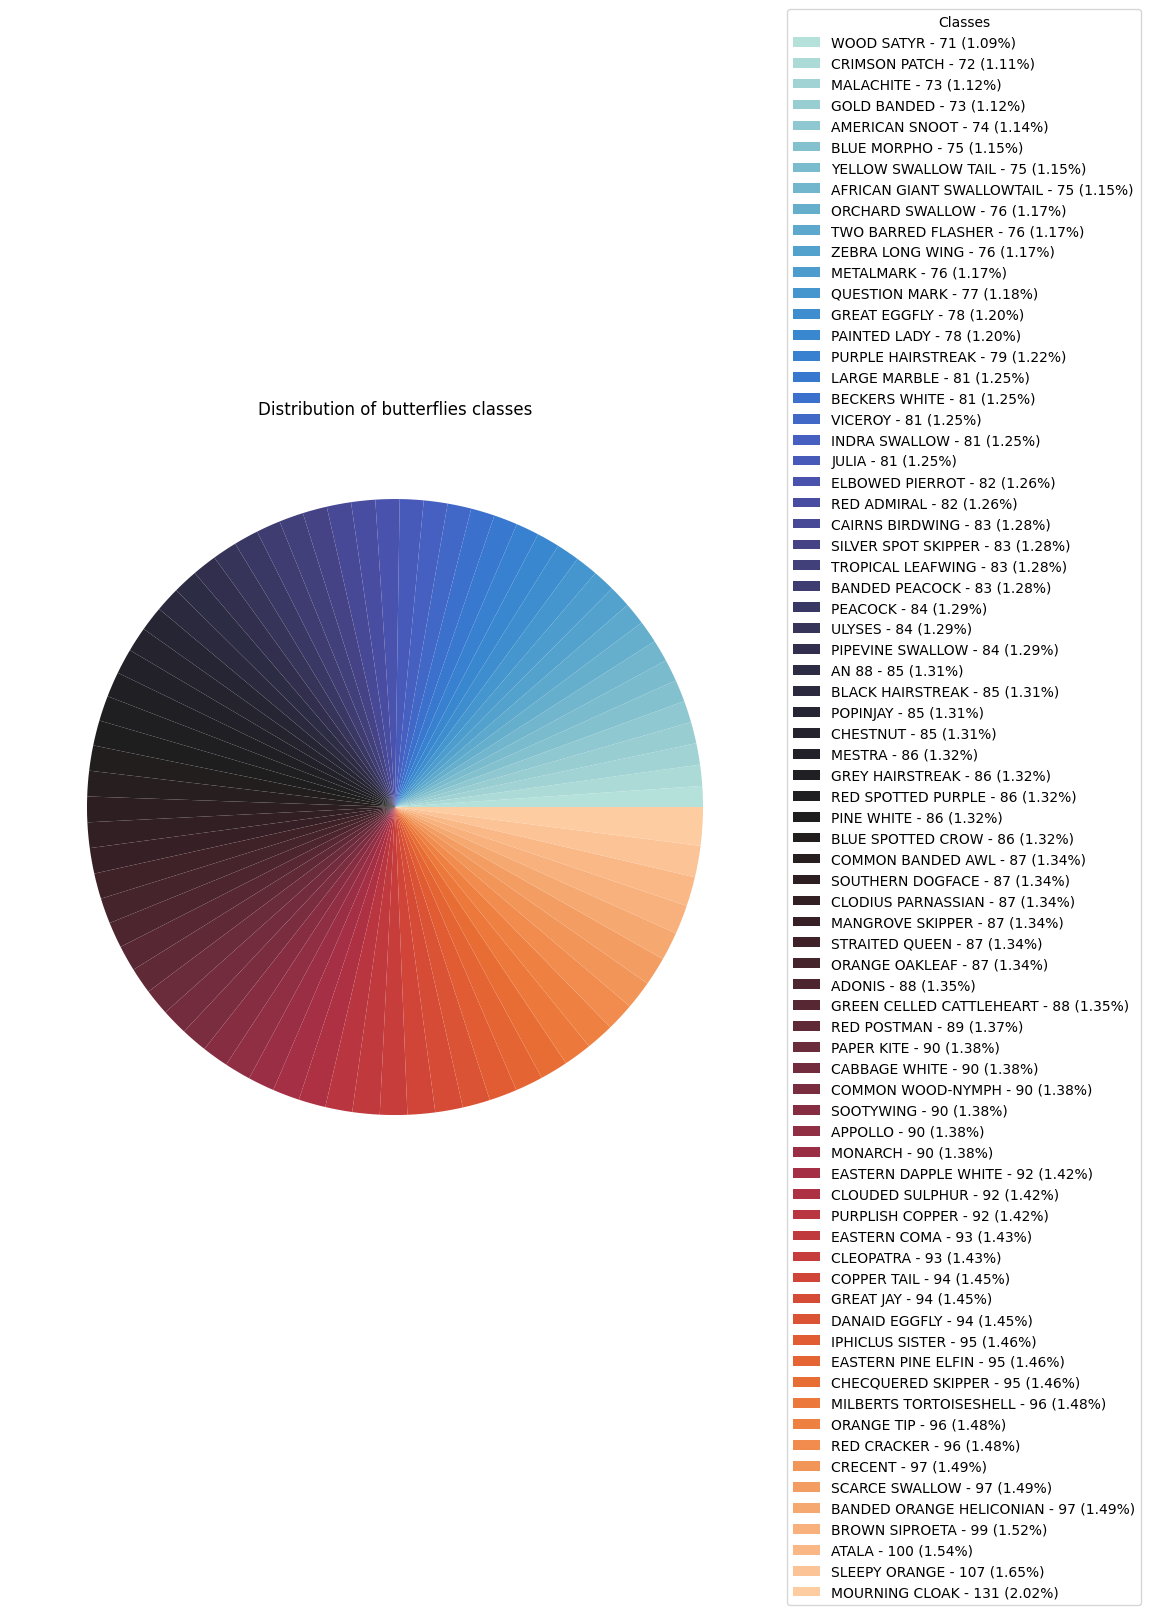

In [248]:
colors = sns.color_palette("icefire", len(class_counter))

labels_proc = [f"{cls} - {count} ({count/class_counter.sum() * 100:.2f}%)" for cls, count in class_counter.items()] 

plt.figure(figsize=(10, 10))
wedges, texts = plt.pie(class_counter.values,
                        labels=None,
                        colors=colors)
plt.title("Distribution of butterflies classes")
plt.legend(wedges, labels_proc, title="Classes", loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

Бачимо, що в кожному класі досить багато представників, проте найбільш представлений клас відрізняється від найменш представленого у два рази, що свідчить про незбаласованість класів, але класи добре представлені, бо значень всеодно багато.

In [249]:
def compute_std(loader):
    stds = []
    for images, _ in loader:
        stds.append(images.std(dim=[0, 2, 3]))
    return torch.stack(stds).mean(dim=0)

In [250]:
noise_level_train = compute_std(train_loader)
print(f"Рівень шуму для тренувального датасету RGB (std): {noise_level_train}")

Рівень шуму для тренувального датасету RGB (std): tensor([0.5165, 0.4983, 0.5185])


In [251]:
noise_level_val = compute_std(val_loader)
print(f"Рівень шуму для валідаційного датасету RGB (std): {noise_level_val}")

Рівень шуму для валідаційного датасету RGB (std): tensor([0.5324, 0.5104, 0.5246])


Рівень шуму на трьох каналах приблизно однаковий і значення близькі до 0.5, тому проблеми із зашумленням зображень немає.

In [252]:
def visualization(data, classes, num_img=5):
    images_shown = 0
    selected_img = []
    selected_label = []
    
    for images, labels in data:
        for i in range(len(labels)):
            label = labels[i].item()
            if label not in selected_label:
                selected_label.append(label)
                selected_img.append(images[i])
                images_shown += 1
            
            if images_shown >= num_img:
                break
    images = [img / 2 + 0.5 for img in selected_img]
    fig, axes = plt.subplots(1, num_img, figsize=(num_img * 3, 3))  

    for i, ax in enumerate(axes):
        img = images[i].permute(1, 2, 0).numpy()
        ax.imshow(img)
        ax.set_title(classes[selected_label[i]], fontsize=10, color="black")
        ax.axis("off")

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


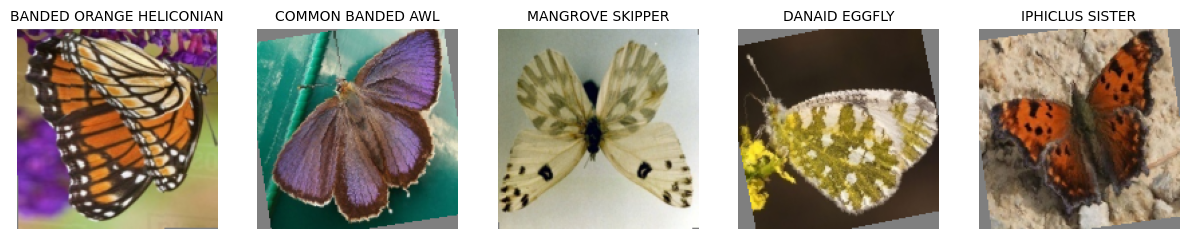

In [253]:
visualization(train_loader, classes)

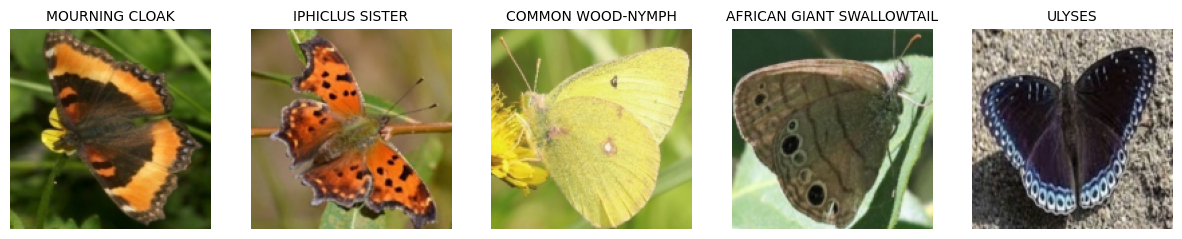

In [254]:
visualization(val_loader, classes)